# CA3 Cell Optimization Using `act`

This notebook shows how to optimize a sample CA3 cell with `act`.

## Prerequisits

Make sure the folder you run this notebook from also contains the following:
- `CA3.hoc`, a .hoc file defining the cell for NEURON.
- `x86_64/` or alternative containing compiled modfiles for the cell. If you have a `modfiles/` folder with uncompiled modfiles, you can compile them by running
    ```bash
        nrnivmodl modfiles
    ```
    in the folder containing `modfiles/`.
- `config.json` which lists optimization settings.
- `example_data.csv` with target data to optimize for.

## Optimization

Although `act` allows to optimize for any NEURON-supported parameter, here we will perform optimization for `gbar_natCA3`. We will be using data generated from a cell with true parameters
- `gbar_natCA3 = 0.09840381518006325`
- `gbar_kdrCA3 = 0.02383466437458992`
- `gbar_napCA3 = 0.0011877061915583909`
- `gbar_imCA3 = 0.010494430549442768`
- `tau_imCA3 = 5`

for current injection values `[0.2, 0.3, 0.4, 0.5, 0.6]`. Note how this information is reflected in both `config.json` and `example_data.csv`.

In [1]:
# Default summary model
from act.feature_model import DefaultSummaryModel

# Default optimizers
from act.optim import SBIOptimizer, NaiveLinearOptimizer, RandomSearchLinearOptimizer

# Default metrics
from act.metrics import mse_score, correlation_score, plot_score

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load observed data
data = torch.tensor(pd.read_csv("example_data.csv", header = None).to_numpy()).float()
print(f"Original data shape: {data.shape}")

# Reshape to (num_current_injections, 1024) for convenience
# Note: be careful with automatic reshaping using .reshape(), since the data is time series
data = data.T

Original data shape: torch.Size([1024, 5])


### Naive Linear Optimizer

In [3]:
# Define optimizer
naive_opt = NaiveLinearOptimizer(config_file = "config.json")

# Optimize
naive_estimates, loss_history = naive_opt.optimize(observed_data = data, num_epochs = 100, lr = 1e-6, return_loss_history = True)

In [4]:
naive_estimates

array([[0.09631509],
       [0.09584308],
       [0.02623975],
       [0.08254597],
       [0.0547986 ]], dtype=float32)

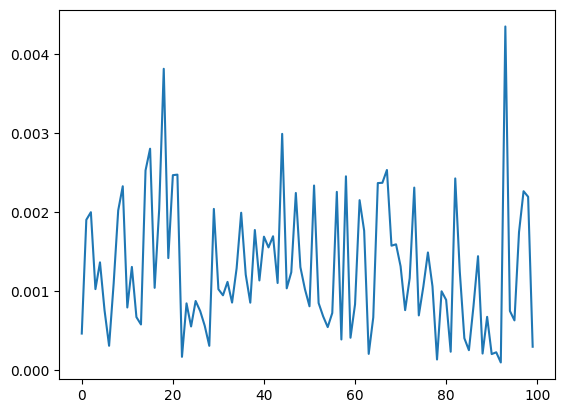

In [5]:
plt.plot(loss_history)

correlation_score: [0.40233925 0.3517546  0.6668008  0.49507153 0.5744166 ]
mse_score: [211.65533 236.10156 197.75868 201.3994  265.09985]


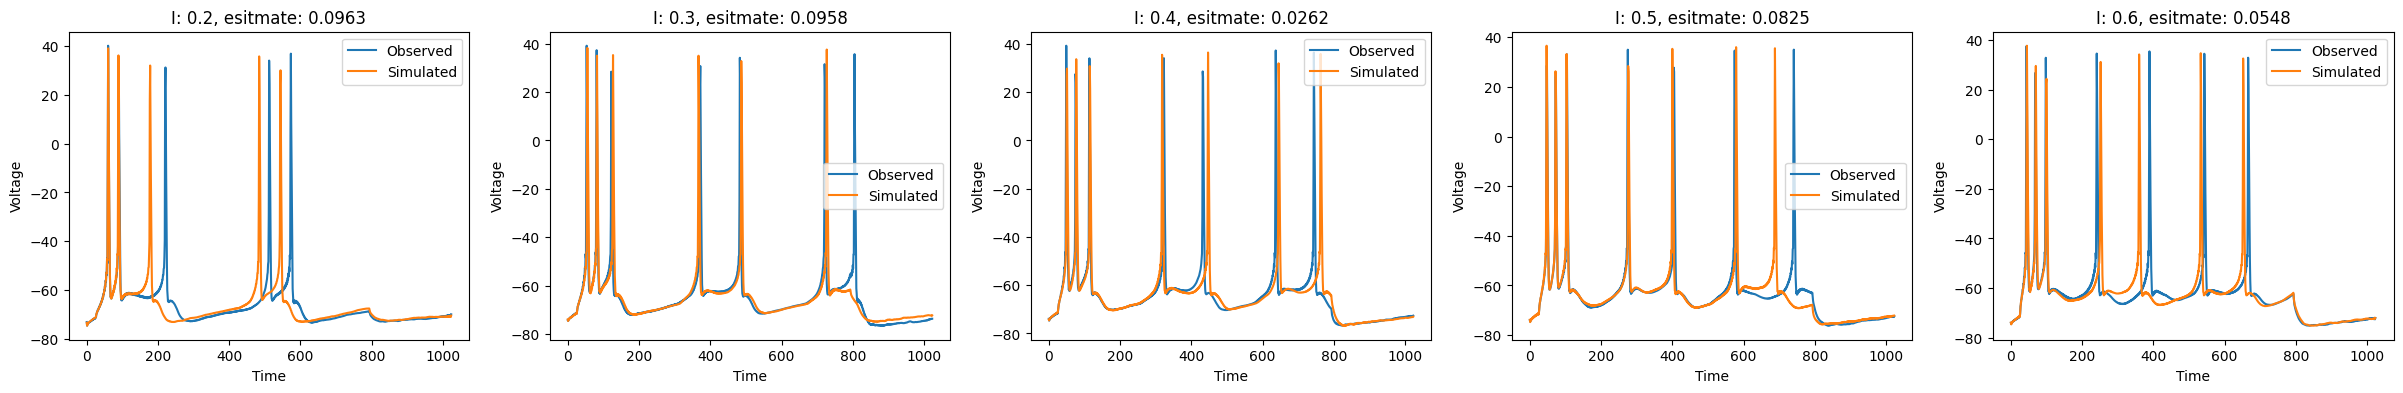

In [6]:
print(f"correlation_score: {correlation_score(naive_opt, data, naive_estimates)}")
print(f"mse_score: {mse_score(naive_opt, data, naive_estimates)}")
plot_score(naive_opt, data, naive_estimates)

### Linear Optimizer

In [7]:
# Define the feature model
feature_model = DefaultSummaryModel(num_summary_features = 61, use_statistics = True)

Total number of summary features: 64


In [8]:
# Define optimizer
linopt = RandomSearchLinearOptimizer(config_file = "config.json")

# Optimize
linopt_estimates, loss_history = linopt.optimize(feature_model = feature_model, observed_data = data, num_summary_features = 64, 
                                                 num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, return_loss_history = True)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
linopt_estimates

array([0.09353925])

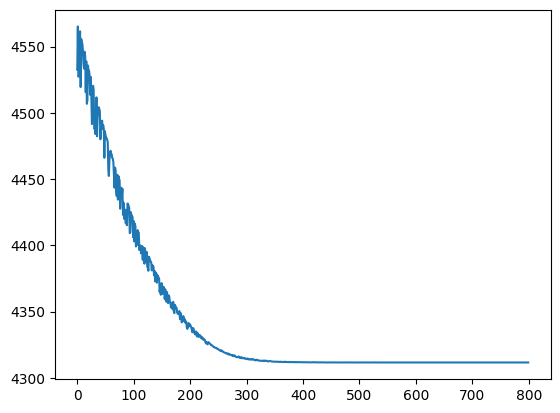

In [10]:
plt.plot(loss_history)

correlation_score: [0.5086238  0.52183163 0.6134114  0.560506   0.44191614]
mse_score: [193.77171 238.16379 193.03157 150.47832 255.39946]


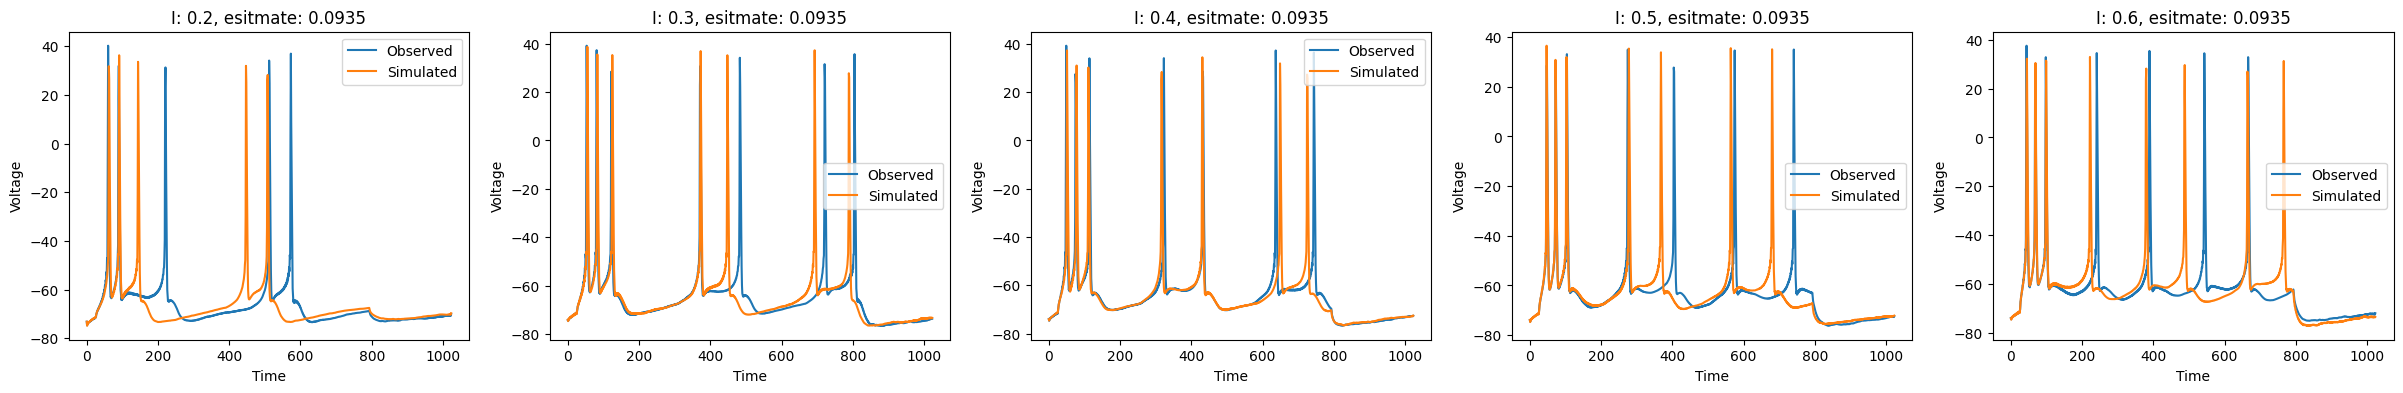

In [16]:
print(f"correlation_score: {correlation_score(linopt, data, linopt_estimates)}")
print(f"mse_score: {mse_score(linopt, data, linopt_estimates)}")
plot_score(linopt, data, np.repeat(linopt_estimates, 5))

#### SBI Optimizer

In [21]:
# Define feature model
feature_model = DefaultSummaryModel(num_summary_features = 61, use_statistics = True)

Total number of summary features: 64


In [22]:
# Define optimizer
sbiopt = SBIOptimizer(config_file = "config.json")

# Optimize
sbi_estimates = sbiopt.optimize(feature_model = feature_model, observed_data = data, num_samples = 1,
                                num_simulations = 100, num_epochs = 1)

/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 61 epochs.
Neural network successfully converged after 192 epochs.
Neural network successfully converged after 177 epochs.
Neural network successfully converged after 40 epochs.
Neural network successfully converged after 23 epochs.


In [23]:
sbi_estimates.shape # (num_current_injections, num_samples, number of parameters)

(5, 1, 1)

correlation_score: [0.2643194  0.33733687 0.39970848 0.3566746  0.42581967]
mse_score: [279.98486 288.14435 257.8528  290.87115 234.68144]


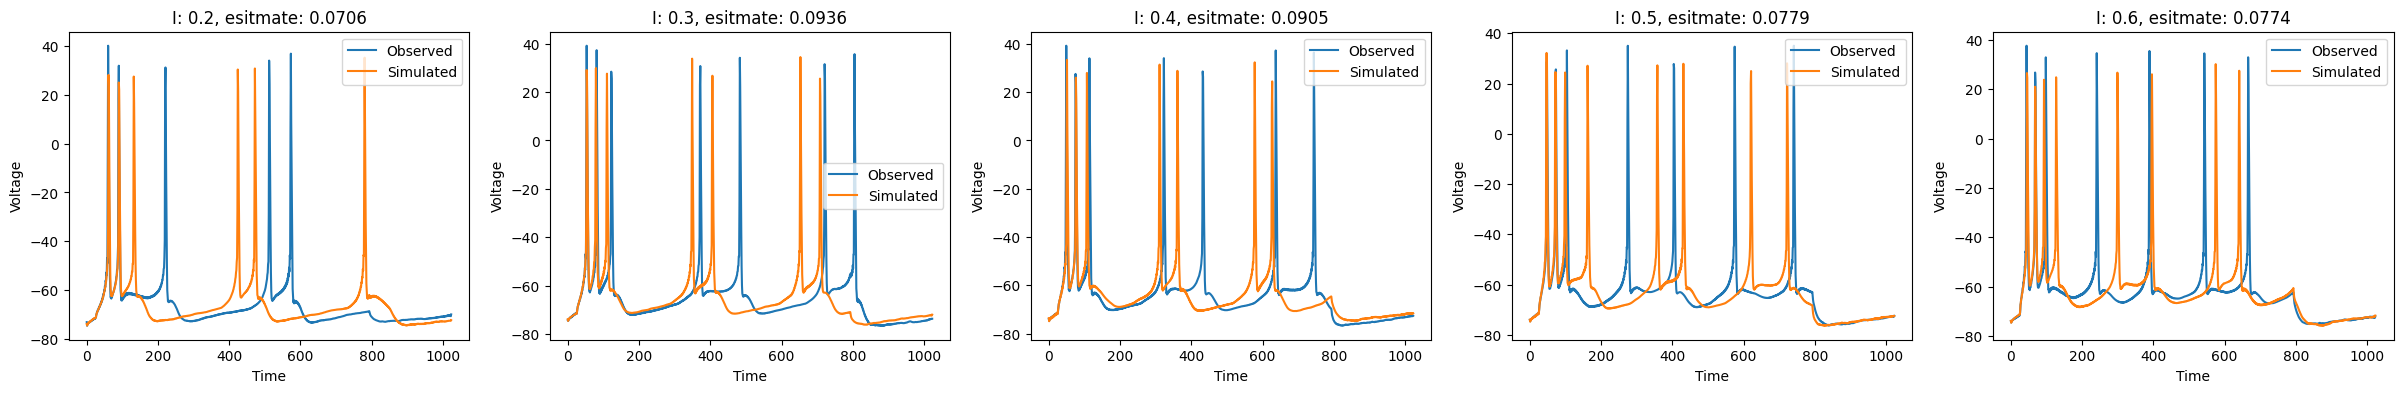

In [24]:
sbi_estimates = sbi_estimates[:, 0, :]

print(f"correlation_score: {correlation_score(sbiopt, data, sbi_estimates)}")
print(f"mse_score: {mse_score(sbiopt, data, sbi_estimates)}")
plot_score(sbiopt, data, sbi_estimates)